##Name - Shashank Singh
##Roll number - 19289
##Department - DSE
##Price prediction using EDA and LSTM


Kindly upload the TATAPOWER-15minute-Hist data set before running the code.


Importing the required libraries.

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import backend as K
from datetime import datetime
import statsmodels.api as sm
#from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.figure_factory as ff
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Getting the data set in the data frame format.

In [ ]:
df = pd.read_pickle('TATAPOWER-15minute-Hist')
df = pd.DataFrame(df)
df['date'] = df['date'].apply(pd.to_datetime)
df.set_index('date',inplace=True)

Visualising the dataset.

In [ ]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['date','open','high','low','close','volume']),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.index,df.open, df.high, df.low, df.close,df.volume],
               fill_color='lavender',
               align='left'))
])

fig.show()

Chart pattern for the given dataset for the opening, high, low and close values.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line

fig = make_subplots(rows=4, cols=1,subplot_titles=('Open','High','Low','Close'))

fig.add_trace(
    Line(x=df.index, y=df.open),
    row=1, col=1
)

fig.add_trace(
    Line(x=df.index, y=df.high),
    row=2, col=1
)

fig.add_trace(
    Line(x=df.index, y=df.low),
    row=3, col=1
)

fig.add_trace(
    go.Line(x=df.index, y=df.close),
    row=4, col=1
)

fig.update_layout(height=1400, width=1000, title_text="OHLC Line Plots")

fig.show()

Following codes visualise the patterns in the data.

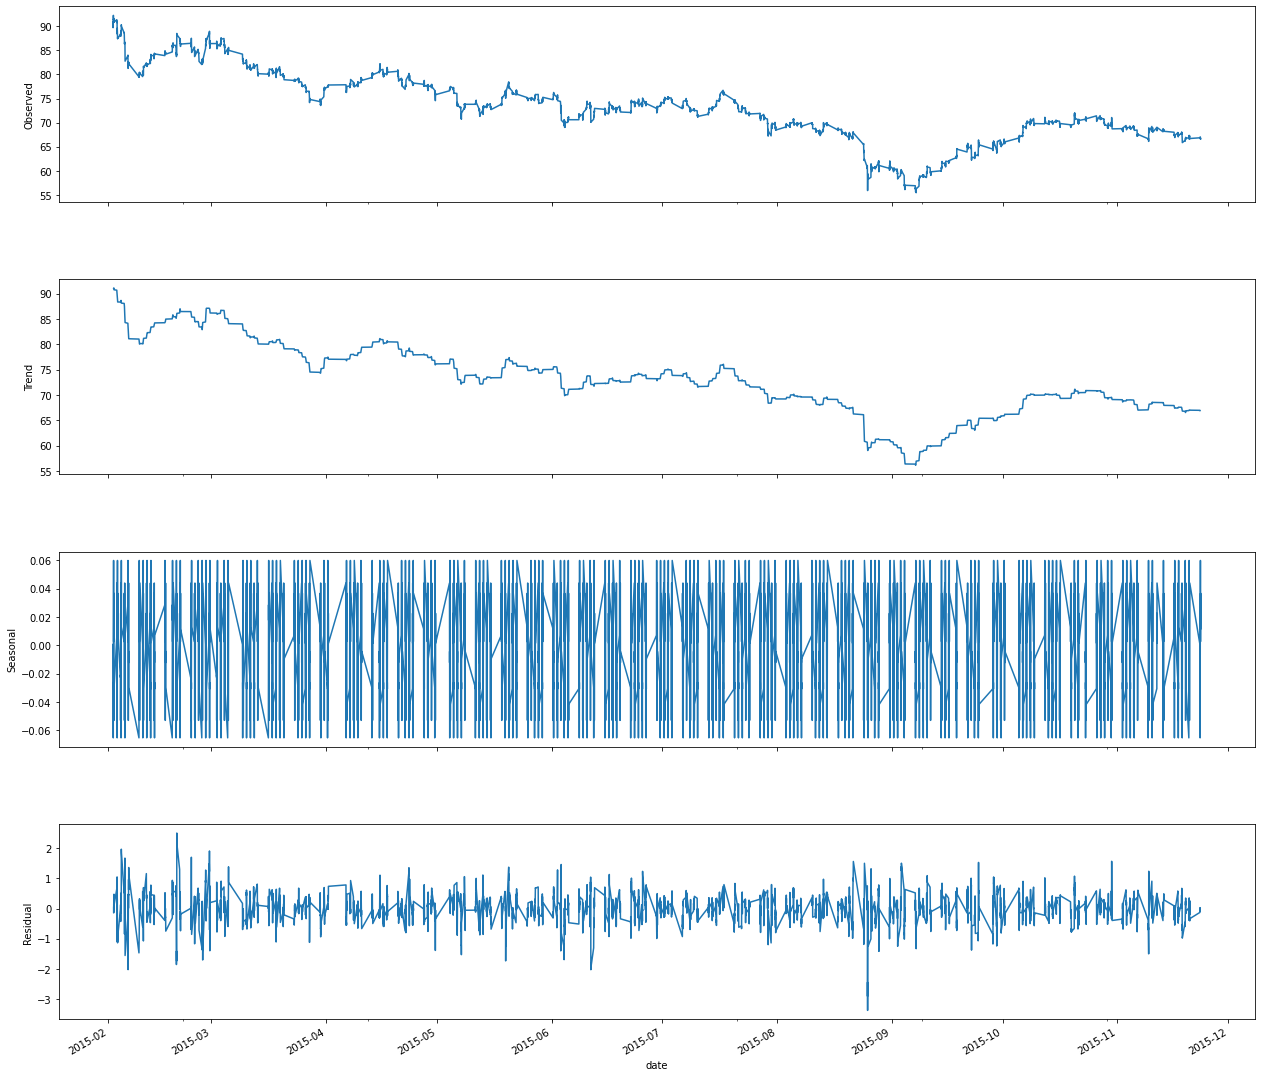

In [ ]:
result = sm.tsa.seasonal_decompose(df.close.head(5000), model='additive', freq = 30)
fig = go.Figure()  
fig = result.plot()  
fig.set_size_inches(20, 19)

Code for plotting the candlestick pattern.

In [ ]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

Creating the training data set


In [ ]:
new_df = pd.DataFrame()
new_df = df['close']
new_df.index = df.index

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_df.values

train_data=final_dataset[0:20000,]
valid_data=final_dataset[20000:,]

In [ ]:
train_df = pd.DataFrame()
valid_df = pd.DataFrame()
train_df['Close'] = train_data
train_df.index = new_df[0:20000].index
valid_df['Close'] = valid_data
valid_df.index = new_df[20000:].index

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset.reshape(-1,1))

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

Long Short Term Memory Networks(LSTM)

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_df[len(new_df)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

lstm_model.summary()

19940/19940 - 507s - loss: 2.3100e-04 - 507s/epoch - 25ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Testing

In [ ]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [ ]:
valid_df['Predictions']=predicted_closing_price

Prediction


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index,y=train_df['Close'],
                    mode='lines',
                    name='Siemens Train Data'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Close'],
                    mode='lines',
                    name='Siemens Valid Data'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Predictions'],
                    mode='lines',
                    name='Prediction'))

In [ ]:
from sklearn.metrics import mean_squared_error
print('The Mean Squared Error is',mean_squared_error(valid_df['Close'].values,valid_df['Predictions'].values))

The Mean Squared Error is 0.23686197922852584


Visualising the test and prediction outcomes.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Close'],
                    mode='lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=valid_df.index,y=valid_df['Predictions'],
                    mode='lines',
                    name='Predicted'))

From the plot obtained we can see from the above visualisation that the LSTM worked well.